In [2]:
from utils import *
import chess as ch
import matplotlib.pyplot as plt

In [3]:

def put_text(text, image, position = (50, 50)):
    image = image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  # Text color in BGR format
    line_type = 2

    # Add text to the image
    cv2.putText(image, text, position, font, font_scale, font_color, line_type)

    return image


In [4]:
def plot_chessboard(statistic):
    plt.imshow(statistic.reshape((8,8)), cmap='viridis', interpolation='nearest')
    plt.colorbar()  # Show color bar
    plt.title('Heatmap of 8x8 Data')
    plt.show()

In [5]:
chessboard = np.array((
    ['h8', 'h7', 'h6', 'h5', 'h4', 'h3', 'h2', 'h1'],
    ['g8', 'g7', 'g6', 'g5', 'g4', 'g3', 'g2', 'g1'],
    ['f8', 'f7', 'f6', 'f5', 'f4', 'f3', 'f2', 'f1'],
    ['e8', 'e7', 'e6', 'e5', 'e4', 'e3', 'e2', 'e1'],
    ['d8', 'd7', 'd6', 'd5', 'd4', 'd3', 'd2', 'd1'],
    ['c8', 'c7', 'c6', 'c5', 'c4', 'c3', 'c2', 'c1'],
    ['b8', 'b7', 'b6', 'b5', 'b4', 'b3', 'b2', 'b1'],
    ['a8', 'a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1'],
))

chessboard = chessboard.reshape(64)

In [6]:
def majority_voting(data, window_size=15):
    result = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        majority = np.sum(data[start:end]) > (window_size / 2)
        result.append(int(majority))
    return np.array(result)

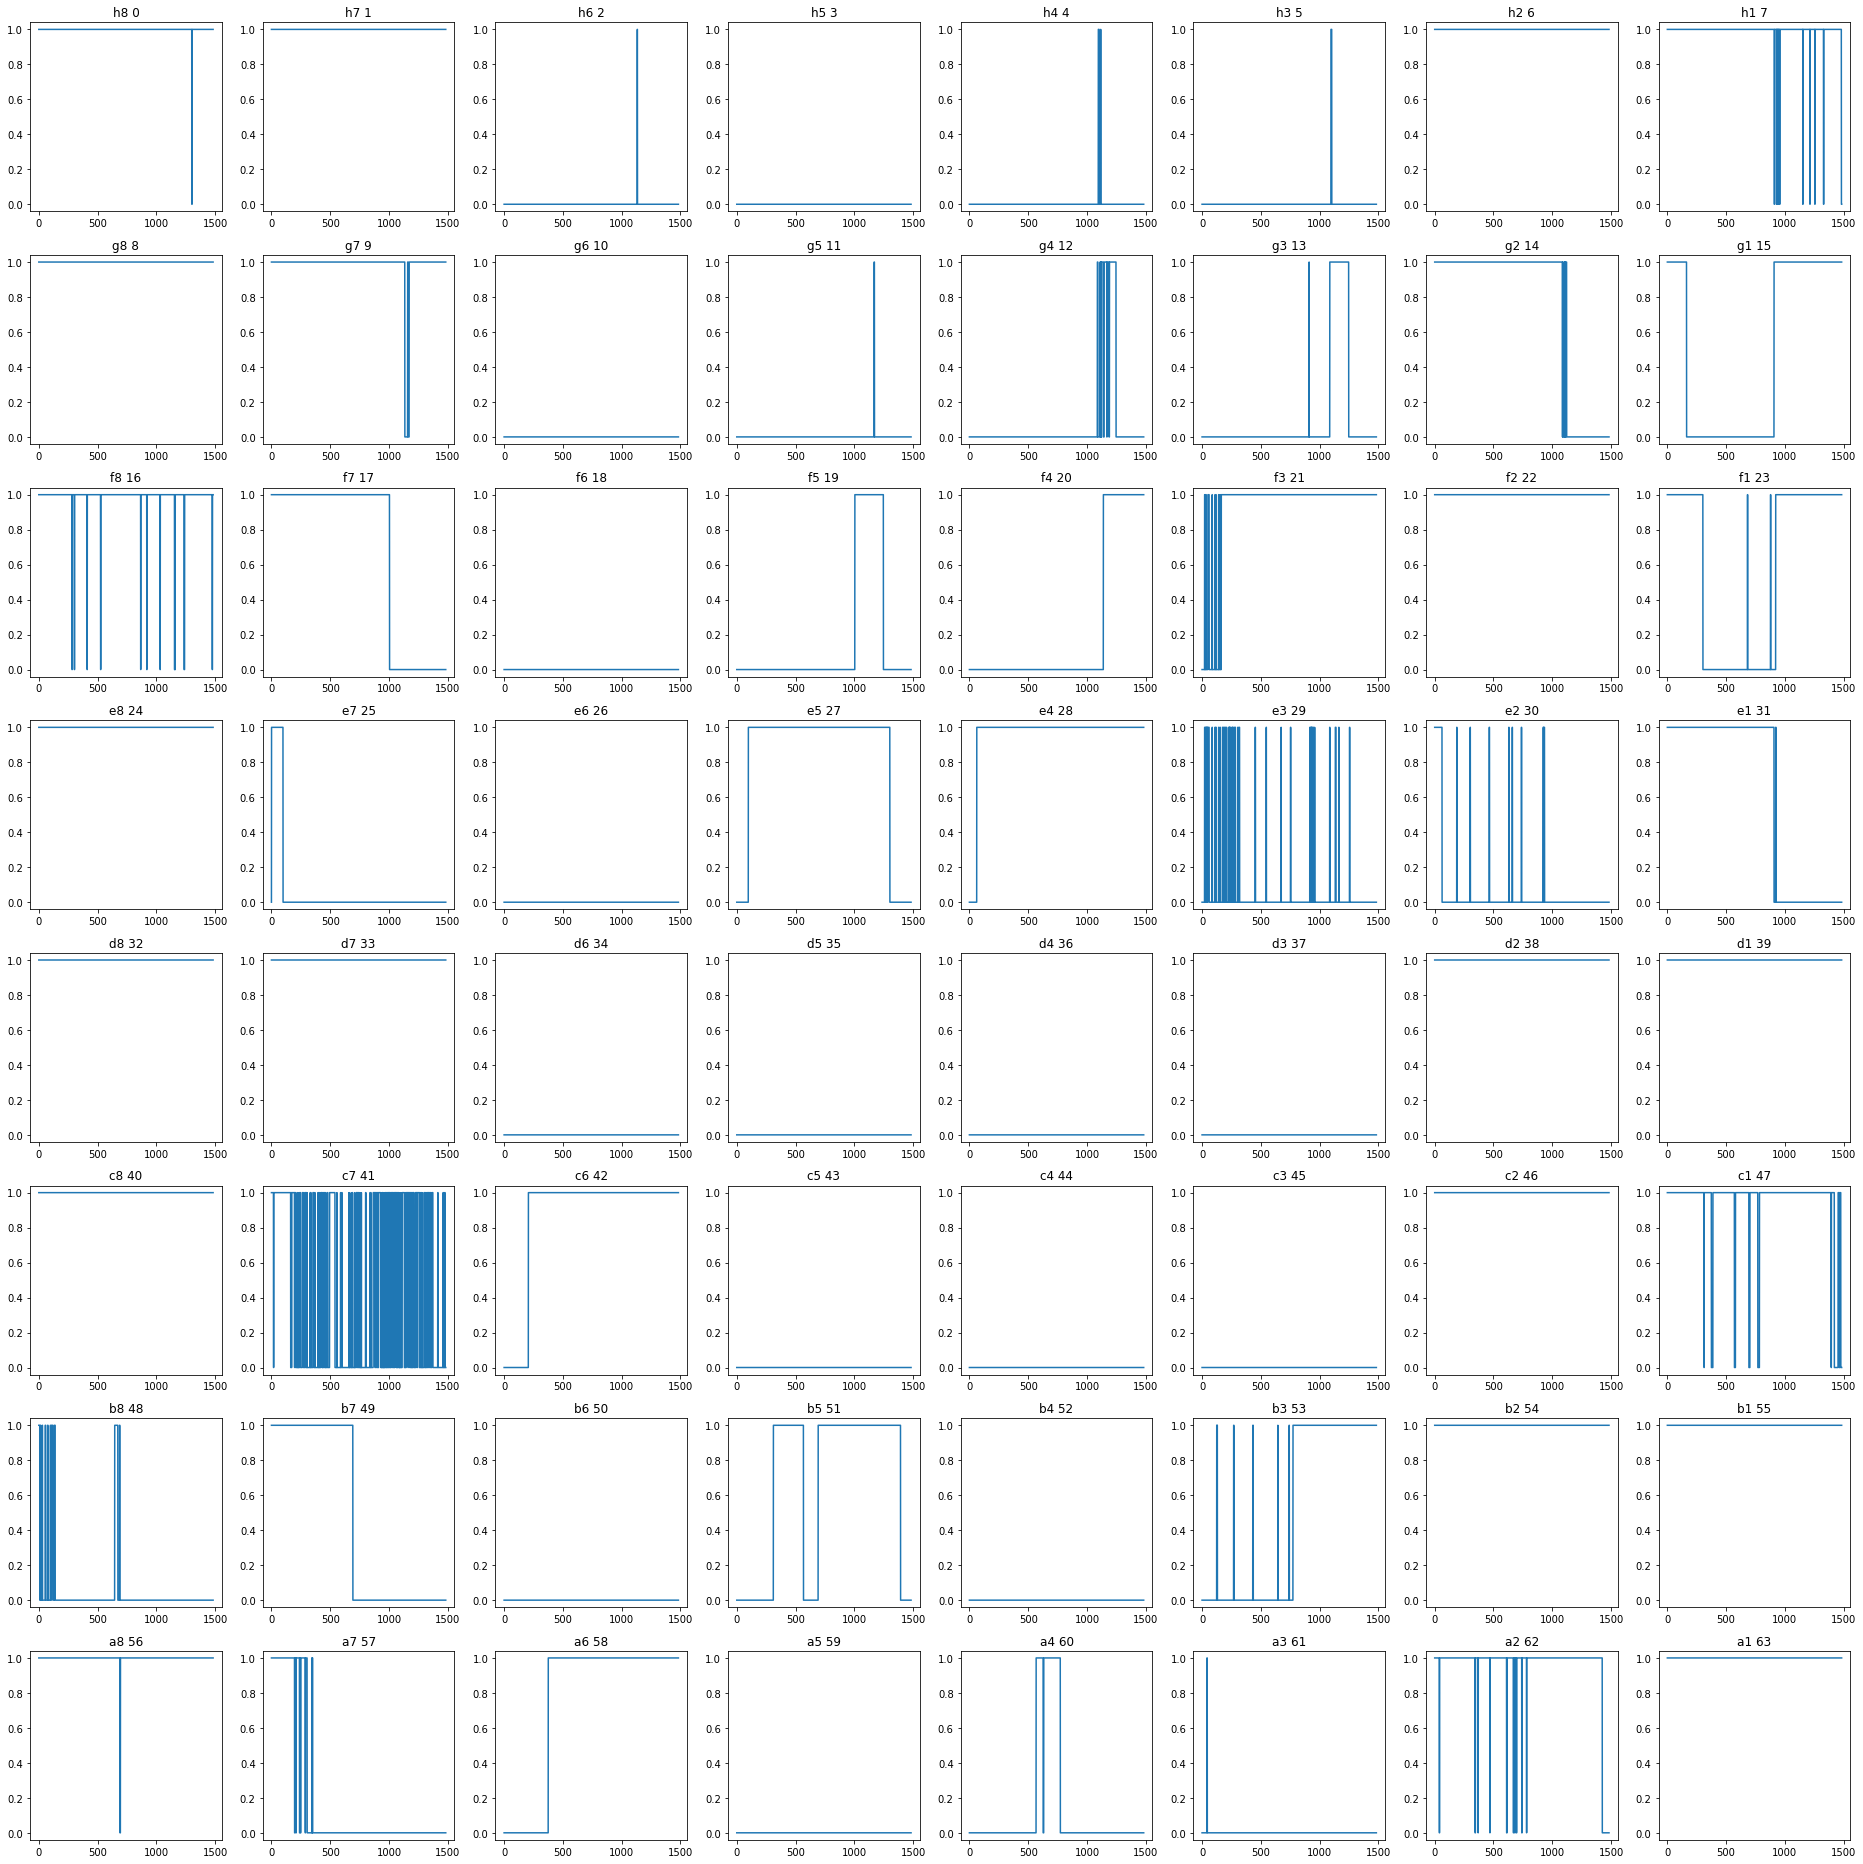

In [70]:
circles_count = np.load(f'circles_centers2/Easy1.npy')
plt.figure(figsize=(26, 26))
data=[]
for x in range(64):
    p=[0 if i==0 else 1 for i in circles_count[:,x] ]
    if x%8<2 or x%8>5:

        p[:p.index(1)]=[1]*p.index(1)
        p=majority_voting(p, window_size=3)
        
       
    else:
        p[:p.index(0)]=[0]*p.index(0)
        p=majority_voting(p, window_size=3)
        
    change_indices = np.where(np.diff(p) != 0)[0]
    plt.subplot(8, 8, x+1)
    plt.plot(p)
    plt.title(chessboard[x]+' '+ str(x))
    plt.ylim(-0.04,1.04)
    data.append(change_indices)
plt.tight_layout()  # Adjust subplot parameters for better layout
plt.show()





In [71]:
big=[]

for x in range(64):
    big.extend([(value, x) for value in data[x]])
big.sort(key=lambda x: x[0])
print(big[42])

board=ch.Board()
moves=[]
for x in range(len(big)):
    for y in range(x, len(big)):
        if big[x][1]!=big[y][1] and big[y][0]-big[x][0]<50 :
            move1=chessboard[big[x][1]]+chessboard[big[y][1]]
        #    move2=chessboard[big[y][1]]+chessboard[big[x][1]]
            if ch.Move.from_uci(move1) in board.legal_moves:
                board.push(ch.Move.from_uci(move1))
                moves.append((move1,  big[x][0], big[y][0]) )
moves

(98, 48)


[('a2a3', 39, 41),
 ('e7e5', 98, 98),
 ('g1f3', 163, 163),
 ('c7c6', 163, 206),
 ('e2e3', 187, 189),
 ('a7a6', 343, 375),
 ('f1b5', 681, 692),
 ('f7f5', 1004, 1004),
 ('g2g4', 1086, 1088),
 ('g7g5', 1134, 1168),
 ('g4f5', 1247, 1247)]

In [9]:
min_value = float('inf')  # Initialize with positive infinity to ensure any value will be smaller
min_index = None

for i, arr in enumerate(data):
    if len(arr) > 0:  # Check if the array is not empty
        current_min = np.min(arr)
        if current_min < min_value:
            min_value = current_min
            min_index = i


29

In [6]:
def detect(video, samples, cut=False):
    if cut:
        circles_count = np.load(f'circles_centers2/{video}.npy')
        used_frames = np.load(f'used_frames/{video}.npy')
    else:
        circles_count = np.load(f'circles_centers/{video}.npy')
    
    
    board = ch.Board()

    made_moves = list()

    for i in range(0, circles_count.shape[0]-samples, samples):
        zeros1 = np.median(circles_count[i:i+samples], axis=0) == 0
        zeros2 = np.median(circles_count[i+samples:i+2*samples], axis=0) == 0
        
        piece_positions = np.array([bool(board.piece_at(square)) for square in ch.SQUARES])
        piece_positions = piece_positions.reshape((8,8)).T
        piece_positions = np.rot90(piece_positions, k=2)
      
        piece_positions = piece_positions.reshape(64)

        undetected_figures = piece_positions & zeros1 & zeros2

        common = zeros1 & zeros2
        zeros1[common] = False
        zeros2[common] = False 

        zeros2[undetected_figures] = True

        if np.sum(zeros1) > 0 and np.sum(zeros2) > 0:
            start_positions = chessboard[zeros2]
            end_positions = chessboard[zeros1]
         
            possible_moves = list()
            for position1 in start_positions:
                for position2 in end_positions:
                    move = position1 + position2
                    if ch.Move.from_uci(move) in board.legal_moves:
                        
                        if board.is_capture(ch.Move.from_uci(move)):
                            move+='+'
                    
                        possible_moves.append(move)
            if len(possible_moves) > 0:
            
                    
                        
                move = possible_moves[0]
             
                board.push(ch.Move.from_uci(move[:4]))

                if cut:
                    idx=np.where(used_frames)[0]
                    if i+2*samples>=len(idx):
                        j=idx[i]
                    else:
                        j=idx[i+samples*2]
      
                    if len(possible_moves)>1:
                        made_moves.append((' '.join(possible_moves), j))
                    else:
                        made_moves.append((move, j))  
                else:
                    if len(possible_moves)>1:
                        made_moves.append((' '.join(possible_moves), i+samples*2))
                    else:
                        made_moves.append((move, i+samples*2))  
        
    return made_moves

In [7]:
def get_bins(m):
    bins=[]
    
    m = [(f, item[1]) for sublist in m for item in sublist for f in item[0].split()]
    m.sort(key=lambda x: x[1])

    while m:
        x=m.pop(0)
        bin=[x]
        if len(m)==0:
            bins.append(bin)
            break
        while m[0][1]-bin[0][1]<0.01*sum([f[1] for f in bin])/len(bin)+20:
            bin.append(m.pop(0))
            if len(m)==0:
                break
        bins.append(bin)
    return bins

In [8]:
from collections import Counter

def unique_sorted_elements(input_list):
    mean=sum([item[1] for item in input_list])/len(input_list)
    element_counts = Counter(item[0] for item in input_list)
    sorted_elements = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)
    unique_sorted_list = ([item[0] for item in sorted_elements], int(mean))
    return unique_sorted_list


In [9]:
def get_data(video):    
    data=[]
    data2=[]
    for i in range(3,25):
        data.append(detect(video, i))
        data2.append(detect(video, i, cut=True))
        
    bin=[x for x in get_bins(data) if len(x)>2 ]
    bin2=[x for x in get_bins(data2) if len(x)>2 ]

    bin=[unique_sorted_elements(x) for x in bin]
    bin2=[unique_sorted_elements(x) for x in bin2]
    bin.extend(bin2)
    bin.sort(key=lambda x: x[1])
    return bin


In [10]:
s=[]
plt.figure(figsize=(14, 10))
for x in range(13):
    p=[]
    for i in range(len(m[x])):
        p.append(m[x][i][1])
    s.append(p)
data_lists=s
for i, data_list in enumerate(data_lists):
    plt.scatter(data_list, [i] * len(data_list), marker='o', label=f'List {i + 1}', alpha=0.7)

plt.yticks(range(len(data_lists)), [f'List {i + 1}' for i in range(len(data_lists))])
plt.xlabel('Values')
plt.title('Scatter Plot of Lists')
plt.legend()
plt.show()
s=[]
plt.figure(figsize=(14, 10))
for x in range(13):
    p=[]
    for i in range(len(m2[x])):
        p.append(m2[x][i][1])
    s.append(p)
data_lists=s
for i, data_list in enumerate(data_lists):
    plt.scatter(data_list, [i] * len(data_list), marker='o', label=f'List {i + 1}', alpha=0.7)

plt.yticks(range(len(data_lists)), [f'List {i + 1}' for i in range(len(data_lists))])
plt.xlabel('Values')
plt.title('Scatter Plot of Lists')
plt.legend()
plt.show()

NameError: name 'm' is not defined

<Figure size 1008x720 with 0 Axes>

In [11]:
bin=get_data('Easy3')
bin

[(['d2d4', 'c2c4'], 97),
 (['e7e5',
   'd7d5',
   'f7f5',
   'f2f4',
   'c1f4',
   'c1h6',
   'e2e4',
   'd2d4',
   'd4d5',
   'c1g5',
   'g7g5',
   'd8g5',
   'g7g6',
   'c7c6',
   'c7c5',
   'g8h6',
   'd7d6',
   'e5d4+',
   'd1d4',
   'f8a3'],
  122),
 (['e7e5',
   'c1g5',
   'g8h6',
   'f2f4',
   'c1f4',
   'd1d4',
   'e2e4',
   'd2d4',
   'g7g6',
   'g7g5',
   'd8g5',
   'd4d5'],
  139),
 (['c1g5', 'h2h4', 'd7d5', 'f8g7', 'g7g6', 'h6g8', 'f4g5+', 'd8g5', 'd8g5+'],
  163),
 (['c1g5'], 179),
 (['f8h6', 'g1f3', 'd1f3'], 222),
 (['g1f3', 'f2f3', 'd1f3', 'e5f4+', 'e2e3', 'd4e3', 'c1e3'], 243),
 (['d8g5', 'c8h3', 'h6g5', 'c7c5'], 275),
 (['e2e3'], 286),
 (['f8a3', 'c7c6', 'c7c5', 'f3h2', 'f8h6', 'f3g1', 'd4c5'], 317),
 (['e2e3'], 324),
 (['f8a3', 'f3h2', 'd4a7+', 'd8c7'], 332),
 (['f4g5+', 'f3g5+', 'f1a6', 'c7c6', 'b8c6', 'c1g5+'], 364),
 (['h6g7', 'g5g3', 'b8a6+', 'b7a6+', 'd8g5+', 'f3g5', 'c1g5+'], 389),
 (['c7c6', 'e2e3', 'f1b5'], 409),
 (['c7c6', 'h1h2'], 413),
 (['f2f4', 'c1f4', 'f

In [334]:
def detect_and_write_moves(video):
    data=get_data(video)
    chess = video_from_path(f'recordings/{video}.mp4')
    used_frames = np.load(f'used_frames/{video}.npy')
    width = int(chess.get(3))
    height = int(chess.get(4))

    fps = chess.get(cv2.CAP_PROP_FPS)

    writer = cv2.VideoWriter(
        f"detection/{video}.mp4",  # Updated filename
        cv2.VideoWriter_fourcc(*"mp4v"),  # Codec for MP4 format (codec might vary)
        fps,
        (width, height),
        True
    )

    i = 0
    j = 0
    k = 0
    made_moves=data
    detected_move = 'no move done'
    next_move = made_moves[0]

    while chess.isOpened():
        hand=''
        ret, frame = chess.read()
        text=f'move: {detected_move}'
        if ret:
            if not used_frames[j]:
                hand='hand detected'
            if next_move[1] == j-7:
                detected_move= ' '.join(next_move[0][:4])
                k += 1
                if k < len(made_moves):

                    next_move = made_moves[k]

            if used_frames[j]: 
                i += 1
          
            image = put_text(text, frame)
            image=put_text(hand, image, (50,100))
            writer.write(image)
            j += 1
            
        else:
            break

    writer.release()
    

In [335]:
d=['Easy', 'Medium', 'Hard']
for i in d:
    for x in range(3):
        vid=i+str(x+1)
        detect_and_write_moves(vid)

Video loaded
912 720
30.00030000300003
Video loaded
920 720
30.00030000300003
Video loaded
876 720
30.00030000300003
Video loaded
866 720
30.00030000300003
Video loaded
884 720
30.00030000300003
Video loaded
876 720
30.00030000300003
Video loaded
816 720
30.00030000300003
Video loaded
798 720
30.00030000300003
Video loaded
720 752
30.00030000300003
